<a href="https://colab.research.google.com/github/RAHULKATARA1/Malaria_Detection-/blob/main/malaria_clean__project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# STEP 1: ENVIRONMENT SETUP
# ============================================================================

# Install required packages
!pip install -q kaggle tensorflow keras scikit-learn matplotlib seaborn opencv-python pillow

# Import all necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_curve, auc, accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import cv2
import warnings
warnings.filterwarnings('ignore')

# Check TensorFlow and GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU'))} GPU(s)")
print(f"Keras version: {keras.__version__}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("\n✓ Environment setup complete!")


TensorFlow version: 2.19.0
GPU Available: 1 GPU(s)
Keras version: 3.10.0

✓ Environment setup complete!


In [2]:
# ============================================================================
# STEP 2: DATASET DOWNLOAD
# ============================================================================

# Create project structure
project_root = "/content/malaria_detection"
os.makedirs(f"{project_root}/data", exist_ok=True)
os.makedirs(f"{project_root}/results", exist_ok=True)
os.makedirs(f"{project_root}/models", exist_ok=True)

print("Project structure created!")

# Upload kaggle.json
from google.colab import files
print("\nPlease upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract dataset
print("\nDownloading malaria dataset (this may take 2-3 minutes)...")
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria -p {project_root}/data
print("Extracting dataset...")
!unzip -q {project_root}/data/cell-images-for-detecting-malaria.zip -d {project_root}/data
print("✓ Dataset downloaded and extracted successfully!")

# Verify dataset
data_dir = f"{project_root}/data/cell_images"
parasitized_dir = os.path.join(data_dir, "Parasitized")
uninfected_dir = os.path.join(data_dir, "Uninfected")

print(f"\nTotal files in Parasitized folder: {len(os.listdir(parasitized_dir))}")
print(f"Total files in Uninfected folder: {len(os.listdir(uninfected_dir))}")


Project structure created!

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
 96% 646M/675M [00:00<00:00, 1.70GB/s]
100% 675M/675M [00:00<00:00, 1.69GB/s]
Extracting dataset...
✓ Dataset downloaded and extracted successfully!

Total files in Parasitized folder: 13780
Total files in Uninfected folder: 13780


In [3]:
# ============================================================================
# STEP 3: DATA LOADING AND PREPROCESSING
# ============================================================================

# Configuration parameters
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
EPOCHS = 15
LEARNING_RATE = 0.0001

print(f"Image Size: {IMG_SIZE}")
print(f"Batch Size: {BATCH_SIZE}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")

# FIXED: Robust data loading with filtering and error handling
def load_data(max_images_per_class=13779):
    """
    Load and preprocess malaria cell images with robust error handling
    """
    images = []
    labels = []
    skipped = {'parasitized': 0, 'uninfected': 0}

    # Load Parasitized images
    print("\n" + "="*60)
    print("LOADING PARASITIZED IMAGES")
    print("="*60)

    # Filter for valid image files only
    valid_parasitized = [f for f in os.listdir(parasitized_dir)
                         if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Valid image files found: {len(valid_parasitized)}")

    for idx, img_name in enumerate(valid_parasitized[:max_images_per_class]):
        img_path = os.path.join(parasitized_dir, img_name)
        try:
            # Load and preprocess image
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0  # Normalize to [0,1]
            images.append(img_array)
            labels.append(1)  # Parasitized = 1

            # Progress indicator
            if (idx + 1) % 2000 == 0:
                print(f"  Loaded {idx + 1}/{len(valid_parasitized[:max_images_per_class])} images...")

        except Exception as e:
            skipped['parasitized'] += 1
            continue

    print(f"✓ Loaded {len([l for l in labels if l == 1])} parasitized images")
    print(f"  Skipped {skipped['parasitized']} corrupted files")

    # Load Uninfected images
    print("\n" + "="*60)
    print("LOADING UNINFECTED IMAGES")
    print("="*60)

    valid_uninfected = [f for f in os.listdir(uninfected_dir)
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    print(f"Valid image files found: {len(valid_uninfected)}")

    for idx, img_name in enumerate(valid_uninfected[:max_images_per_class]):
        img_path = os.path.join(uninfected_dir, img_name)
        try:
            img = load_img(img_path, target_size=IMG_SIZE)
            img_array = img_to_array(img) / 255.0
            images.append(img_array)
            labels.append(0)  # Uninfected = 0

            if (idx + 1) % 2000 == 0:
                print(f"  Loaded {idx + 1}/{len(valid_uninfected[:max_images_per_class])} images...")

        except Exception as e:
            skipped['uninfected'] += 1
            continue

    print(f"✓ Loaded {len([l for l in labels if l == 0])} uninfected images")
    print(f"  Skipped {skipped['uninfected']} corrupted files")

    return np.array(images, dtype='float32'), np.array(labels, dtype='int32')

# Load the dataset
print("\nStarting data loading process...")
X, y = load_data(max_images_per_class=13779)

print("\n" + "="*60)
print("DATA LOADING SUMMARY")
print("="*60)
print(f"Total images loaded: {len(X)}")
print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Image data type: {X.dtype}")
print(f"Label data type: {y.dtype}")
print(f"Image value range: [{X.min():.3f}, {X.max():.3f}]")
print(f"Parasitized (1): {np.sum(y == 1)}")
print(f"Uninfected (0): {np.sum(y == 0)}")
print(f"Class balance: {np.sum(y == 1) / len(y) * 100:.1f}% parasitized")


Image Size: (160, 160)
Batch Size: 32
Epochs: 15
Learning Rate: 0.0001

Starting data loading process...

LOADING PARASITIZED IMAGES
Valid image files found: 13779
  Loaded 2000/13779 images...
  Loaded 4000/13779 images...
  Loaded 6000/13779 images...
  Loaded 8000/13779 images...
  Loaded 10000/13779 images...
  Loaded 12000/13779 images...
✓ Loaded 13779 parasitized images
  Skipped 0 corrupted files

LOADING UNINFECTED IMAGES
Valid image files found: 13779
  Loaded 2000/13779 images...
  Loaded 4000/13779 images...
  Loaded 6000/13779 images...
  Loaded 8000/13779 images...
  Loaded 10000/13779 images...
  Loaded 12000/13779 images...
✓ Loaded 13779 uninfected images
  Skipped 0 corrupted files

DATA LOADING SUMMARY
Total images loaded: 27558
Dataset shape: (27558, 160, 160, 3)
Labels shape: (27558,)
Image data type: float32
Label data type: int32
Image value range: [0.000, 1.000]
Parasitized (1): 13779
Uninfected (0): 13779
Class balance: 50.0% parasitized


In [4]:
# ============================================================================
# STEP 4: DATA SPLITTING AND AUGMENTATION
# ============================================================================

# Split data: 70% train, 20% val, 10% test
print("\nSplitting data...")
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y, shuffle=True
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp, shuffle=True
)

print("\n" + "="*60)
print("DATA SPLIT SUMMARY")
print("="*60)
print(f"Training set: {X_train.shape[0]} images")
print(f"  Parasitized: {np.sum(y_train == 1)} | Uninfected: {np.sum(y_train == 0)}")
print(f"\nValidation set: {X_val.shape[0]} images")
print(f"  Parasitized: {np.sum(y_val == 1)} | Uninfected: {np.sum(y_val == 0)}")
print(f"\nTest set: {X_test.shape[0]} images")
print(f"  Parasitized: {np.sum(y_test == 1)} | Uninfected: {np.sum(y_test == 0)}")

# Verify labels
print(f"\nTrain labels unique values: {np.unique(y_train)}")
print(f"Val labels unique values: {np.unique(y_val)}")
print(f"Test labels unique values: {np.unique(y_test)}")

# Setup data augmentation for training
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

print("\n✓ Data split and augmentation setup complete!")



Splitting data...

DATA SPLIT SUMMARY
Training set: 19290 images
  Parasitized: 9645 | Uninfected: 9645

Validation set: 5539 images
  Parasitized: 2770 | Uninfected: 2769

Test set: 2729 images
  Parasitized: 1364 | Uninfected: 1365

Train labels unique values: [0 1]
Val labels unique values: [0 1]
Test labels unique values: [0 1]

✓ Data split and augmentation setup complete!


In [5]:
# ============================================================================
# STEP 5: BASELINE CNN MODEL (IMPROVED)
# ============================================================================

def build_improved_baseline_cnn():
    """
    Improved baseline CNN with better architecture
    """
    model = keras.Sequential([
        layers.Input(shape=(160, 160, 3)),

        # Block 1
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 3
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Block 4
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Dense layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ], name='Baseline_CNN')

    return model

print("Building Baseline CNN model...")
baseline_model = build_improved_baseline_cnn()

# Compile model
baseline_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

baseline_model.summary()

# Define callbacks
callbacks = [
    ModelCheckpoint(
        f'{project_root}/models/Baseline_CNN_best.h5',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Train model
print("\n" + "="*60)
print("TRAINING BASELINE CNN")
print("="*60)

baseline_history = baseline_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

# Save final model
baseline_model.save(f'{project_root}/models/Baseline_CNN_final.h5')
print("\n✓ Baseline CNN training complete!")

# Evaluate on test set
print("\nEvaluating on test set...")
test_results = baseline_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_results[1]:.4f}")
print(f"Test AUC: {test_results[4]:.4f}")


Building Baseline CNN model...


Model: "Baseline_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 80, 80, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 80, 80, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 80, 80, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 40, 40, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 40, 40, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 20, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 13,827,361 (52.75 MB)

 Trainable params: 13,824,417 (52.74 MB)

 Non-trainable params: 2,944 (11.50 KB)


TRAINING BASELINE CNN
Epoch 1/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6156 - auc: 0.6566 - loss: 0.8522 - precision: 0.6176 - recall: 0.6120
Epoch 1: val_accuracy improved from -inf to 0.50298, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 135s 193ms/step - accuracy: 0.6157 - auc: 0.6568 - loss: 0.8520 - precision: 0.6177 - recall: 0.6121 - val_accuracy: 0.5030 - val_auc: 0.5609 - val_loss: 5.1283 - val_precision: 1.0000 - val_recall: 0.0061 - learning_rate: 1.0000e-04
Epoch 2/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - accuracy: 0.7188 - auc: 0.8039 - loss: 0.5575 - precision: 0.7143 - recall: 0.6667
Epoch 2: val_accuracy did not improve from 0.50298
602/602 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7188 - auc: 0.8039 - loss: 0.5575 - precision: 0.7143 - recall: 0.6667 - val_accuracy: 0.5030 - val_auc: 0.5616 - val_loss: 5.0696 - val_precision: 1.0000 - val_recall: 0.0061 - learning_rate: 1.0000e-04
Epoch 3/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8614 - auc: 0.9270 - loss: 0.3665 - precision: 0.8998 - recall: 0.8159
Epoch 3: val_accuracy improved from 0.50298 to 0.63261, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 100s 166ms/step - accuracy: 0.8615 - auc: 0.9270 - loss: 0.3664 - precision: 0.8999 - recall: 0.8159 - val_accuracy: 0.6326 - val_auc: 0.8179 - val_loss: 2.6801 - val_precision: 0.9946 - val_recall: 0.2668 - learning_rate: 1.0000e-04
Epoch 4/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9375 - auc: 0.9686 - loss: 0.1578 - precision: 0.9412 - recall: 0.9412
Epoch 4: val_accuracy improved from 0.63261 to 0.63369, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9375 - auc: 0.9686 - loss: 0.1578 - precision: 0.9412 - recall: 0.9412 - val_accuracy: 0.6337 - val_auc: 0.8189 - val_loss: 2.6363 - val_precision: 0.9947 - val_recall: 0.2690 - learning_rate: 1.0000e-04
Epoch 5/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9207 - auc: 0.9631 - loss: 0.2398 - precision: 0.9379 - recall: 0.8987
Epoch 5: val_accuracy improved from 0.63369 to 0.76602, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 100s 166ms/step - accuracy: 0.9207 - auc: 0.9631 - loss: 0.2398 - precision: 0.9379 - recall: 0.8987 - val_accuracy: 0.7660 - val_auc: 0.8910 - val_loss: 1.6053 - val_precision: 0.9894 - val_recall: 0.5379 - learning_rate: 1.0000e-04
Epoch 6/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8750 - auc: 0.9570 - loss: 0.3233 - precision: 0.9286 - recall: 0.8125
Epoch 6: val_accuracy did not improve from 0.76602
602/602 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8750 - auc: 0.9570 - loss: 0.3233 - precision: 0.9286 - recall: 0.8125 - val_accuracy: 0.7637 - val_auc: 0.8907 - val_loss: 1.6595 - val_precision: 0.9886 - val_recall: 0.5336 - learning_rate: 1.0000e-04
Epoch 7/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9325 - auc: 0.9716 - loss: 0.2049 - precision: 0.9475 - recall: 0.9167
Epoch 7: val_accuracy improved from 0.76602 to 0.83282, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 101s 167ms/step - accuracy: 0.9325 - auc: 0.9716 - loss: 0.2049 - precision: 0.9475 - recall: 0.9167 - val_accuracy: 0.8328 - val_auc: 0.9379 - val_loss: 0.9368 - val_precision: 0.9863 - val_recall: 0.6751 - learning_rate: 1.0000e-04
Epoch 8/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.9062 - auc: 0.9481 - loss: 0.4180 - precision: 1.0000 - recall: 0.8571
Epoch 8: val_accuracy did not improve from 0.83282
602/602 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9062 - auc: 0.9481 - loss: 0.4180 - precision: 1.0000 - recall: 0.8571 - val_accuracy: 0.8308 - val_auc: 0.9375 - val_loss: 0.9495 - val_precision: 0.9867 - val_recall: 0.6708 - learning_rate: 1.0000e-04
Epoch 9/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9414 - auc: 0.9753 - loss: 0.1868 - precision: 0.9545 - recall: 0.9286
Epoch 9: val_accuracy improved from 0.83282 to 0.85142, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 100s 167ms/step - accuracy: 0.9414 - auc: 0.9753 - loss: 0.1868 - precision: 0.9545 - recall: 0.9286 - val_accuracy: 0.8514 - val_auc: 0.9443 - val_loss: 0.7090 - val_precision: 0.9865 - val_recall: 0.7126 - learning_rate: 1.0000e-04
Epoch 10/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9375 - auc: 1.0000 - loss: 0.1282 - precision: 1.0000 - recall: 0.9000
Epoch 10: val_accuracy improved from 0.85142 to 0.85340, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9375 - auc: 1.0000 - loss: 0.1282 - precision: 1.0000 - recall: 0.9000 - val_accuracy: 0.8534 - val_auc: 0.9444 - val_loss: 0.7045 - val_precision: 0.9861 - val_recall: 0.7170 - learning_rate: 1.0000e-04
Epoch 11/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.9444 - auc: 0.9764 - loss: 0.1831 - precision: 0.9536 - recall: 0.9346
Epoch 11: val_accuracy improved from 0.85340 to 0.90305, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 100s 166ms/step - accuracy: 0.9444 - auc: 0.9764 - loss: 0.1831 - precision: 0.9536 - recall: 0.9346 - val_accuracy: 0.9031 - val_auc: 0.9389 - val_loss: 0.4984 - val_precision: 0.9693 - val_recall: 0.8325 - learning_rate: 1.0000e-04
Epoch 12/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - accuracy: 0.9688 - auc: 0.9961 - loss: 0.1078 - precision: 0.9375 - recall: 1.0000
Epoch 12: val_accuracy did not improve from 0.90305
602/602 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - auc: 0.9961 - loss: 0.1078 - precision: 0.9375 - recall: 1.0000 - val_accuracy: 0.9031 - val_auc: 0.9381 - val_loss: 0.4956 - val_precision: 0.9693 - val_recall: 0.8325 - learning_rate: 1.0000e-04
Epoch 13/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9430 - auc: 0.9771 - loss: 0.1780 - precision: 0.9538 - recall: 0.9310
Epoch 13: val_accuracy did not improve from 0.90305
602/602 ━━━━━━━━━━━━━━━━━━━━ 100s 166ms/step - accuracy: 0.9430 - auc: 0.9771 - loss: 0.1780 - 

602/602 ━━━━━━━━━━━━━━━━━━━━ 101s 167ms/step - accuracy: 0.9424 - auc: 0.9785 - loss: 0.1729 - precision: 0.9506 - recall: 0.9321 - val_accuracy: 0.9269 - val_auc: 0.9690 - val_loss: 0.3903 - val_precision: 0.9646 - val_recall: 0.8863 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.



✓ Baseline CNN training complete!

Evaluating on test set...
Test Accuracy: 0.9300
Test AUC: 0.9748


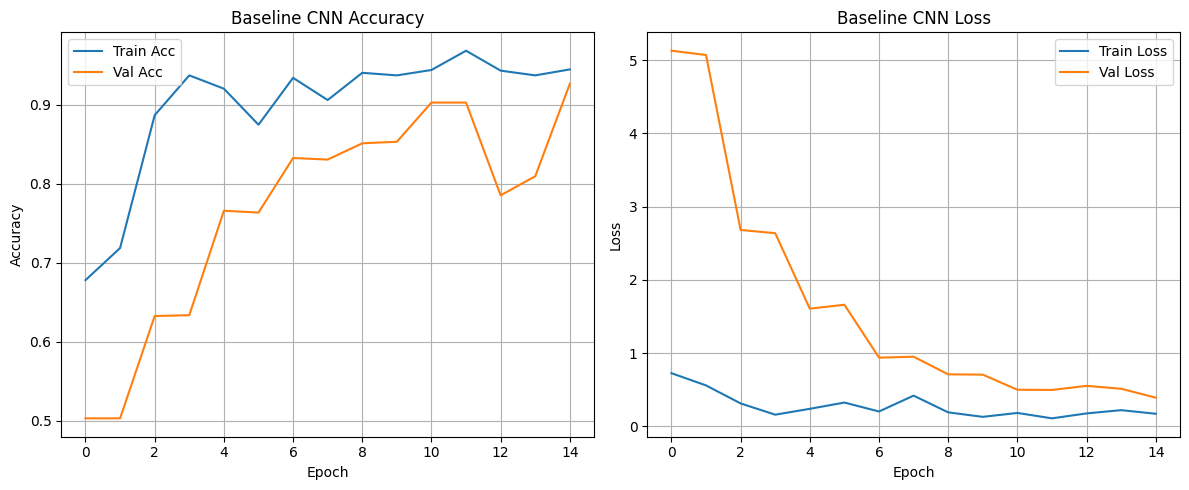

In [7]:
# --- Save Accuracy and Loss Curve for This Model ---

def plot_training_history(history, model_name, save_path):
    # Plot Accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Save Baseline CNN graphs
plot_training_history(
    baseline_history,
    'Baseline CNN',
    f'{project_root}/results/baseline_cnn_training.png'
)



BUILDING RESNET50 TRANSFER LEARNING MODEL
Preprocessing data for ResNet50...
ResNet preprocessed data shape: (19290, 160, 160, 3)
ResNet preprocessed value range: [-123.68, 142.06]
Building improved ResNet50 model...
Total layers: 14
Trainable layers: 13

PHASE 1: TRAINING RESNET50 (FROZEN BASE)
Epoch 1/10
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7746 - auc: 0.8503 - loss: 1.6181 - precision: 0.7683 - recall: 0.8022
Epoch 1: val_accuracy improved from -inf to 0.89222, saving model to /content/malaria_detection/models/ResNet50_initial.keras
602/602 ━━━━━━━━━━━━━━━━━━━━ 136s 201ms/step - accuracy: 0.7747 - auc: 0.8504 - loss: 1.6179 - precision: 0.7684 - recall: 0.8022 - val_accuracy: 0.8922 - val_auc: 0.9659 - val_loss: 1.3739 - val_precision: 0.9540 - val_recall: 0.8242 - learning_rate: 1.0000e-04
Epoch 2/10
  1/602 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.8438 - auc: 0.9437 - loss: 1.4281 - precision: 0.7143 - recall: 0.9091
Epoch 2: val_accuracy improved from

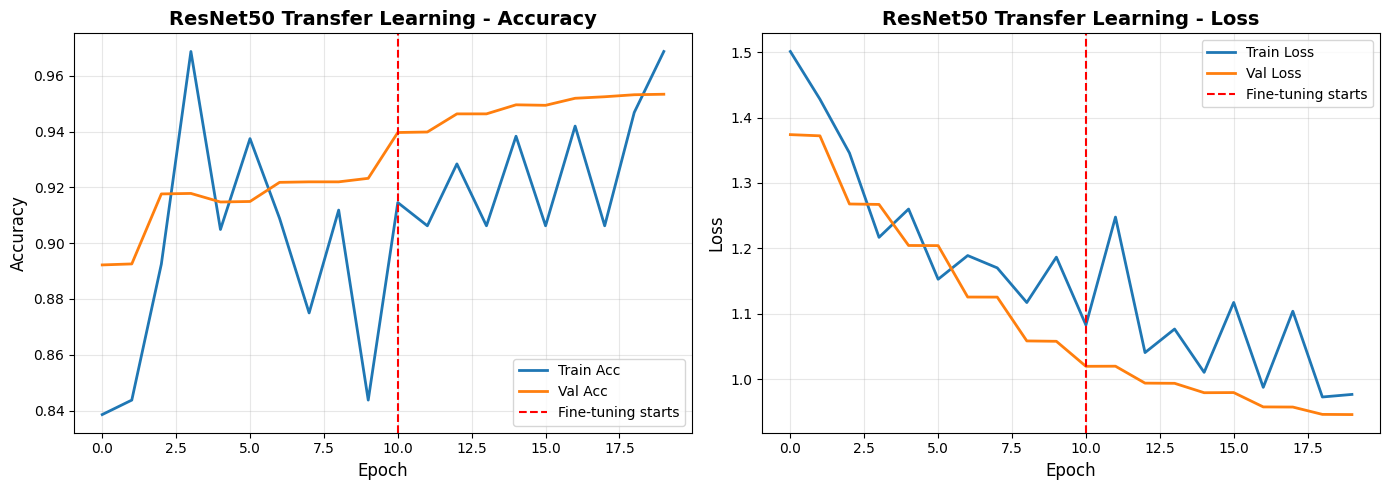

✓ Training curves saved to /content/malaria_detection/results/resnet50_training.png

✓ RESNET50 TRANSFER LEARNING COMPLETE!


In [9]:
# ============================================================================
# STEP 6: RESNET50 TRANSFER LEARNING (IMPROVED FOR >90% ACCURACY)
# ============================================================================

from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess

print("\n" + "="*60)
print("BUILDING RESNET50 TRANSFER LEARNING MODEL")
print("="*60)

# -----------------------------------------------------------------
# PART A: PREPROCESS DATA FOR RESNET50 (IMPORTANT!)
# -----------------------------------------------------------------

# ResNet50 expects specific preprocessing
# We'll create preprocessed versions of our data
print("Preprocessing data for ResNet50...")

# Undo our [0,1] normalization and apply ResNet preprocessing
X_train_resnet = resnet_preprocess(X_train * 255.0)
X_val_resnet = resnet_preprocess(X_val * 255.0)
X_test_resnet = resnet_preprocess(X_test * 255.0)

print(f"ResNet preprocessed data shape: {X_train_resnet.shape}")
print(f"ResNet preprocessed value range: [{X_train_resnet.min():.2f}, {X_train_resnet.max():.2f}]")

# -----------------------------------------------------------------
# PART B: BUILD RESNET50 MODEL WITH IMPROVED ARCHITECTURE
# -----------------------------------------------------------------

def build_improved_resnet50():
    """
    Improved ResNet50 architecture for malaria detection
    """
    # Load pre-trained ResNet50
    base_model = ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(160, 160, 3)
    )

    # Initially freeze all base layers
    base_model.trainable = False

    # Build classification head
    inputs = layers.Input(shape=(160, 160, 3))
    x = base_model(inputs, training=False)

    # Enhanced classification layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name='ResNet50_Improved')
    return model, base_model

print("Building improved ResNet50 model...")
resnet_model, resnet_base = build_improved_resnet50()

print(f"Total layers: {len(resnet_model.layers)}")
print(f"Trainable layers: {sum([layer.trainable for layer in resnet_model.layers])}")

# -----------------------------------------------------------------
# PART C: INITIAL TRAINING (FROZEN BASE)
# -----------------------------------------------------------------

# Compile with higher learning rate for initial training
resnet_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Define callbacks for initial training
initial_callbacks = [
    ModelCheckpoint(
        f'{project_root}/models/ResNet50_initial.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

# Create data generator for ResNet (lighter augmentation)
resnet_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

print("\n" + "="*60)
print("PHASE 1: TRAINING RESNET50 (FROZEN BASE)")
print("="*60)

resnet_history_initial = resnet_model.fit(
    resnet_datagen.flow(X_train_resnet, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val_resnet, y_val),
    epochs=10,
    steps_per_epoch=len(X_train_resnet) // BATCH_SIZE,
    callbacks=initial_callbacks,
    verbose=1
)

print("\n✓ Initial training complete!")

# Evaluate after initial training
initial_results = resnet_model.evaluate(X_val_resnet, y_val, verbose=0)
print(f"After Phase 1 - Val Accuracy: {initial_results[1]:.4f}, Val AUC: {initial_results[4]:.4f}")

# -----------------------------------------------------------------
# PART D: FINE-TUNING (UNFREEZE TOP LAYERS)
# -----------------------------------------------------------------

print("\n" + "="*60)
print("PHASE 2: FINE-TUNING RESNET50 (UNFROZEN TOP LAYERS)")
print("="*60)

# Unfreeze the last 30 layers of ResNet50
resnet_base.trainable = True

# Freeze all layers except last 30
total_layers = len(resnet_base.layers)
freeze_until = total_layers - 30

for layer in resnet_base.layers[:freeze_until]:
    layer.trainable = False

print(f"Unfrozen last {30} layers of ResNet50 base")
print(f"Now trainable layers: {sum([layer.trainable for layer in resnet_model.layers])}")

# Recompile with much lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Very low LR for fine-tuning
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall'),
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Callbacks for fine-tuning
finetune_callbacks = [
    ModelCheckpoint(
        f'{project_root}/models/ResNet50_finetuned.keras',
        save_best_only=True,
        monitor='val_accuracy',
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-8,
        verbose=1
    )
]

# Fine-tune the model
resnet_history_finetune = resnet_model.fit(
    resnet_datagen.flow(X_train_resnet, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val_resnet, y_val),
    epochs=10,
    steps_per_epoch=len(X_train_resnet) // BATCH_SIZE,
    callbacks=finetune_callbacks,
    verbose=1
)

print("\n✓ Fine-tuning complete!")

# -----------------------------------------------------------------
# PART E: FINAL EVALUATION
# -----------------------------------------------------------------

print("\n" + "="*60)
print("FINAL RESNET50 EVALUATION")
print("="*60)

# Evaluate on validation set
val_results = resnet_model.evaluate(X_val_resnet, y_val, verbose=0)
print(f"\nValidation Set:")
print(f"  Accuracy:  {val_results[1]:.4f}")
print(f"  Precision: {val_results[2]:.4f}")
print(f"  Recall:    {val_results[3]:.4f}")
print(f"  AUC:       {val_results[4]:.4f}")

# Evaluate on test set
test_results = resnet_model.evaluate(X_test_resnet, y_test, verbose=0)
print(f"\nTest Set:")
print(f"  Accuracy:  {test_results[1]:.4f}")
print(f"  Precision: {test_results[2]:.4f}")
print(f"  Recall:    {test_results[3]:.4f}")
print(f"  AUC:       {test_results[4]:.4f}")

# Save final model
resnet_model.save(f'{project_root}/models/ResNet50_TL_final.keras')
print("\n✓ ResNet50 model saved!")

# -----------------------------------------------------------------
# PART F: PLOT TRAINING CURVES
# -----------------------------------------------------------------

def plot_resnet_training_history(history_initial, history_finetune, model_name, save_path):
    """
    Plot combined training history from both phases
    """
    # Combine histories
    combined_acc = history_initial.history['accuracy'] + history_finetune.history['accuracy']
    combined_val_acc = history_initial.history['val_accuracy'] + history_finetune.history['val_accuracy']
    combined_loss = history_initial.history['loss'] + history_finetune.history['loss']
    combined_val_loss = history_initial.history['val_loss'] + history_finetune.history['val_loss']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Accuracy
    axes[0].plot(combined_acc, label='Train Acc', linewidth=2)
    axes[0].plot(combined_val_acc, label='Val Acc', linewidth=2)
    axes[0].axvline(x=len(history_initial.history['accuracy']),
                    color='red', linestyle='--', label='Fine-tuning starts')
    axes[0].set_title(f'{model_name} - Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Plot Loss
    axes[1].plot(combined_loss, label='Train Loss', linewidth=2)
    axes[1].plot(combined_val_loss, label='Val Loss', linewidth=2)
    axes[1].axvline(x=len(history_initial.history['loss']),
                    color='red', linestyle='--', label='Fine-tuning starts')
    axes[1].set_title(f'{model_name} - Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Training curves saved to {save_path}")

# Plot combined training history
plot_resnet_training_history(
    resnet_history_initial,
    resnet_history_finetune,
    'ResNet50 Transfer Learning',
    f'{project_root}/results/resnet50_training.png'
)

print("\n" + "="*60)
print("✓ RESNET50 TRANSFER LEARNING COMPLETE!")
print("="*60)


In [10]:
# ============================================================================
# STEP 7: DENSENET121 TRANSFER LEARNING
# ============================================================================

def build_densenet_model():
    """
    DenseNet121 with transfer learning
    """
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=(160, 160, 3)
    )

    base_model.trainable = False

    inputs = layers.Input(shape=(160, 160, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs, name='DenseNet121_TL')
    return model

print("Building DenseNet121 model...")
densenet_model = build_densenet_model()

densenet_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

print("\n" + "="*60)
print("TRAINING DENSENET121")
print("="*60)

densenet_history = densenet_model.fit(
    train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=len(X_train) // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

densenet_model.save(f'{project_root}/models/DenseNet121_TL.h5')
print("\n✓ DenseNet121 training complete!")


Building DenseNet121 model...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step

TRAINING DENSENET121
Epoch 1/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8168 - auc: 0.8932 - loss: 0.3881 - precision: 0.8234 - recall: 0.8059
Epoch 1: val_accuracy did not improve from 0.92688
602/602 ━━━━━━━━━━━━━━━━━━━━ 175s 240ms/step - accuracy: 0.8169 - auc: 0.8933 - loss: 0.3880 - precision: 0.8235 - recall: 0.8060 - val_accuracy: 0.9056 - val_auc: 0.9762 - val_loss: 0.2280 - val_precision: 0.9618 - val_recall: 0.8448 - learning_rate: 1.0000e-04
Epoch 2/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.0700 - precision: 1.0000 - recall: 0.9500
Epoch 2: val_accuracy did not improve from 0.92688
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9688 - auc: 1.0000 - loss: 0.0700 - precision: 1.0000 - recall: 0.9500 - val_accuracy: 0.9050 - val_auc: 0.9762 - val_loss: 0.2306 - val_precision: 0.9617 - val_recall: 0.8437 - learning_rate: 1.0000

602/602 ━━━━━━━━━━━━━━━━━━━━ 103s 170ms/step - accuracy: 0.9156 - auc: 0.9700 - loss: 0.2201 - precision: 0.9222 - recall: 0.9088 - val_accuracy: 0.9294 - val_auc: 0.9802 - val_loss: 0.1803 - val_precision: 0.9440 - val_recall: 0.9130 - learning_rate: 1.0000e-04
Epoch 4/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.8750 - auc: 0.9827 - loss: 0.2764 - precision: 0.7333 - recall: 1.0000
Epoch 4: val_accuracy improved from 0.92941 to 0.92995, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8750 - auc: 0.9827 - loss: 0.2764 - precision: 0.7333 - recall: 1.0000 - val_accuracy: 0.9300 - val_auc: 0.9803 - val_loss: 0.1799 - val_precision: 0.9444 - val_recall: 0.9137 - learning_rate: 1.0000e-04
Epoch 5/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9292 - auc: 0.9763 - loss: 0.1937 - precision: 0.9333 - recall: 0.9246
Epoch 5: val_accuracy improved from 0.92995 to 0.93410, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 103s 171ms/step - accuracy: 0.9292 - auc: 0.9763 - loss: 0.1937 - precision: 0.9333 - recall: 0.9246 - val_accuracy: 0.9341 - val_auc: 0.9821 - val_loss: 0.1712 - val_precision: 0.9509 - val_recall: 0.9155 - learning_rate: 1.0000e-04
Epoch 6/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9688 - auc: 0.9843 - loss: 0.1337 - precision: 0.9444 - recall: 1.0000
Epoch 6: val_accuracy did not improve from 0.93410
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9688 - auc: 0.9843 - loss: 0.1337 - precision: 0.9444 - recall: 1.0000 - val_accuracy: 0.9339 - val_auc: 0.9820 - val_loss: 0.1715 - val_precision: 0.9509 - val_recall: 0.9152 - learning_rate: 1.0000e-04
Epoch 7/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9309 - auc: 0.9783 - loss: 0.1843 - precision: 0.9339 - recall: 0.9270
Epoch 7: val_accuracy improved from 0.93410 to 0.93501, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


602/602 ━━━━━━━━━━━━━━━━━━━━ 103s 170ms/step - accuracy: 0.9309 - auc: 0.9782 - loss: 0.1843 - precision: 0.9339 - recall: 0.9270 - val_accuracy: 0.9350 - val_auc: 0.9837 - val_loss: 0.1711 - val_precision: 0.9663 - val_recall: 0.9014 - learning_rate: 1.0000e-04
Epoch 8/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9062 - auc: 1.0000 - loss: 0.1605 - precision: 1.0000 - recall: 0.8571
Epoch 8: val_accuracy did not improve from 0.93501

Epoch 8: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9062 - auc: 1.0000 - loss: 0.1605 - precision: 1.0000 - recall: 0.8571 - val_accuracy: 0.9348 - val_auc: 0.9838 - val_loss: 0.1714 - val_precision: 0.9667 - val_recall: 0.9007 - learning_rate: 1.0000e-04
Epoch 9/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9389 - auc: 0.9808 - loss: 0.1721 - precision: 0.9431 - recall: 0.9341
Epoch 9: val_accuracy improved from 0.93501 to 0.93663, saving model to 

602/602 ━━━━━━━━━━━━━━━━━━━━ 102s 170ms/step - accuracy: 0.9389 - auc: 0.9808 - loss: 0.1721 - precision: 0.9431 - recall: 0.9341 - val_accuracy: 0.9366 - val_auc: 0.9843 - val_loss: 0.1723 - val_precision: 0.9693 - val_recall: 0.9018 - learning_rate: 5.0000e-05
Epoch 10/15
  1/602 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.9375 - auc: 1.0000 - loss: 0.1084 - precision: 0.8462 - recall: 1.0000
Epoch 10: val_accuracy did not improve from 0.93663
602/602 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9375 - auc: 1.0000 - loss: 0.1084 - precision: 0.8462 - recall: 1.0000 - val_accuracy: 0.9365 - val_auc: 0.9843 - val_loss: 0.1720 - val_precision: 0.9693 - val_recall: 0.9014 - learning_rate: 5.0000e-05
Epoch 11/15
602/602 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.9357 - auc: 0.9792 - loss: 0.1789 - precision: 0.9418 - recall: 0.9271
Epoch 11: val_accuracy did not improve from 0.93663

Epoch 11: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
602/602 ━━━━━━━━


✓ DenseNet121 training complete!


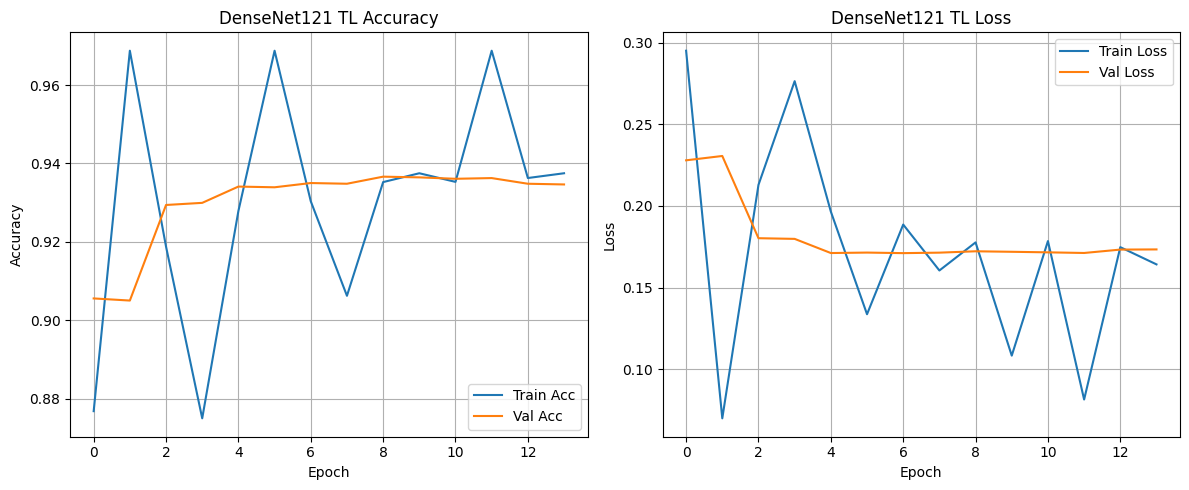

In [11]:
# --- Save Accuracy and Loss Curve for This Model ---

def plot_training_history(history, model_name, save_path):
    # Plot Accuracy
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

# Save Baseline CNN graphs
plot_training_history(
    densenet_history,
    'DenseNet121 TL',
    f'{project_root}/results/densenet121_training.png'
)



In [12]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
import time

# If using preprocess_input elsewhere, do it here too:
X_train_cbam = resnet_preprocess(X_train * 255.0)
X_val_cbam   = resnet_preprocess(X_val * 255.0)

print("Shapes and dtypes:")
print("X_train_cbam:", X_train_cbam.shape, X_train_cbam.dtype)
print("X_val_cbam:", X_val_cbam.shape, X_val_cbam.dtype)
print("y_train:", y_train.shape, y_train.dtype)
print("y_val:", y_val.shape, y_val.dtype)

batch = next(iter(train_datagen.flow(X_train_cbam, y_train, batch_size=32)))
print("Test batch shapes:", batch[0].shape, batch[1].shape)

# -----------------------------------------------------------------
# CBAM Definitions (keep same as your version!)
# -----------------------------------------------------------------

class ChannelAttention(layers.Layer):
    def __init__(self, channels, ratio=8, **kwargs):
        super().__init__(**kwargs)
        self.channels = channels
        self.ratio = ratio
    def build(self, input_shape):
        self.dense1 = layers.Dense(self.channels // self.ratio, activation='relu')
        self.dense2 = layers.Dense(self.channels)
    def call(self, inputs):
        avg_pool = layers.GlobalAveragePooling2D()(inputs)
        avg_pool = layers.Reshape((1, 1, self.channels))(avg_pool)
        avg_pool = self.dense1(avg_pool)
        avg_pool = self.dense2(avg_pool)
        max_pool = layers.GlobalMaxPooling2D()(inputs)
        max_pool = layers.Reshape((1, 1, self.channels))(max_pool)
        max_pool = self.dense1(max_pool)
        max_pool = self.dense2(max_pool)
        attention = layers.Add()([avg_pool, max_pool])
        attention = layers.Activation('sigmoid')(attention)
        return layers.Multiply()([inputs, attention])

class SpatialAttention(layers.Layer):
    def __init__(self, kernel_size=7, **kwargs):
        super().__init__(**kwargs)
        self.kernel_size = kernel_size
    def build(self, input_shape):
        self.conv = layers.Conv2D(1, self.kernel_size, padding='same', activation='sigmoid')
    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=-1, keepdims=True)
        concat = layers.Concatenate()([avg_pool, max_pool])
        attention = self.conv(concat)
        return layers.Multiply()([inputs, attention])

class CBAM(layers.Layer):
    def __init__(self, channels, **kwargs):
        super().__init__(**kwargs)
        self.channel_attention = ChannelAttention(channels)
        self.spatial_attention = SpatialAttention()
    def call(self, inputs):
        x = self.channel_attention(inputs)
        x = self.spatial_attention(x)
        return x

# -----------------------------------------------------------------
# Build Model
# -----------------------------------------------------------------

def build_resnet50_cbam():
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=X_train_cbam.shape[1:])
    base_model.trainable = False
    inputs = layers.Input(shape=X_train_cbam.shape[1:])
    x = base_model(inputs, training=False)
    cbam = CBAM(channels=x.shape[-1])
    x = cbam(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return Model(inputs, outputs, name='ResNet50_CBAM')

print("Building ResNet50 + CBAM...")
cbam_model = build_resnet50_cbam()
cbam_model.summary()

cbam_model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall', 'auc']
)

# -----------------------------------------------------------------
# Train Model (direct arrays for debugging start)
# -----------------------------------------------------------------

print("\n" + "="*60)
print("TRAINING RESNET50 + CBAM")
print("="*60)

start_time = time.time()

cbam_history = cbam_model.fit(
    X_train_cbam, y_train,
    validation_data=(X_val_cbam, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,  # Only use if you confirmed above they're safe
    verbose=1
)

end_time = time.time()
print(f"\nTraining completed in {(end_time-start_time)/60:.2f} minutes!")

cbam_model.save(f'{project_root}/models/ResNet50_CBAM.keras')
print("\n✓ ResNet50 + CBAM training complete!")

# Optional: Switch back to generator fit after confirming success
# cbam_history = cbam_model.fit(
#     train_datagen.flow(X_train_cbam, y_train, batch_size=BATCH_SIZE),
#     validation_data=(X_val_cbam, y_val),
#     epochs=EPOCHS,
#     steps_per_epoch=len(X_train_cbam) // BATCH_SIZE,
#     callbacks=callbacks,
#     verbose=1
# )


Shapes and dtypes:
X_train_cbam: (19290, 160, 160, 3) float32
X_val_cbam: (5539, 160, 160, 3) float32
y_train: (19290,) int32
y_val: (5539,) int32
Test batch shapes: (32, 160, 160, 3) (32,)
Building ResNet50 + CBAM...


Model: "ResNet50_CBAM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 5, 5, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam (CBAM)                     │ (None, 5, 5, 2048)     │     1,050,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,827,556 (98.52 MB)

 Trainable params: 2,235,748 (8.53 MB)

 Non-trainable params: 23,591,808 (90.00 MB)


TRAINING RESNET50 + CBAM
Epoch 1/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8670 - auc: 0.9346 - loss: 0.3097 - precision: 0.8708 - recall: 0.8567
Epoch 1: val_accuracy improved from 0.93663 to 0.94421, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.8671 - auc: 0.9346 - loss: 0.3096 - precision: 0.8709 - recall: 0.8568 - val_accuracy: 0.9442 - val_auc: 0.9849 - val_loss: 0.1543 - val_precision: 0.9509 - val_recall: 0.9368 - learning_rate: 1.0000e-04
Epoch 2/15
600/603 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9366 - auc: 0.9817 - loss: 0.1700 - precision: 0.9377 - recall: 0.9338
Epoch 2: val_accuracy improved from 0.94421 to 0.94674, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 13s 22ms/step - accuracy: 0.9366 - auc: 0.9817 - loss: 0.1700 - precision: 0.9377 - recall: 0.9338 - val_accuracy: 0.9467 - val_auc: 0.9865 - val_loss: 0.1456 - val_precision: 0.9558 - val_recall: 0.9368 - learning_rate: 1.0000e-04
Epoch 3/15
602/603 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9463 - auc: 0.9861 - loss: 0.1477 - precision: 0.9479 - recall: 0.9431
Epoch 3: val_accuracy did not improve from 0.94674
603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9463 - auc: 0.9861 - loss: 0.1477 - precision: 0.9479 - recall: 0.9432 - val_accuracy: 0.9446 - val_auc: 0.9852 - val_loss: 0.1650 - val_precision: 0.9684 - val_recall: 0.9191 - learning_rate: 1.0000e-04
Epoch 4/15
600/603 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9523 - auc: 0.9888 - loss: 0.1295 - precision: 0.9527 - recall: 0.9506
Epoch 4: val_accuracy improved from 0.94674 to 0.95089, saving model to /content/malaria_detection/models/Baseline_CNN_best.h5


603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9523 - auc: 0.9888 - loss: 0.1295 - precision: 0.9527 - recall: 0.9506 - val_accuracy: 0.9509 - val_auc: 0.9876 - val_loss: 0.1392 - val_precision: 0.9552 - val_recall: 0.9462 - learning_rate: 1.0000e-04
Epoch 5/15
603/603 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.9598 - auc: 0.9917 - loss: 0.1109 - precision: 0.9596 - recall: 0.9590
Epoch 5: val_accuracy did not improve from 0.95089
603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9598 - auc: 0.9917 - loss: 0.1109 - precision: 0.9596 - recall: 0.9590 - val_accuracy: 0.9386 - val_auc: 0.9864 - val_loss: 0.1629 - val_precision: 0.9161 - val_recall: 0.9657 - learning_rate: 1.0000e-04
Epoch 6/15
600/603 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9648 - auc: 0.9939 - loss: 0.0954 - precision: 0.9664 - recall: 0.9621
Epoch 6: val_accuracy did not improve from 0.95089
603/603 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9648 - auc: 0.9939 - loss: 0.0954 - precisi

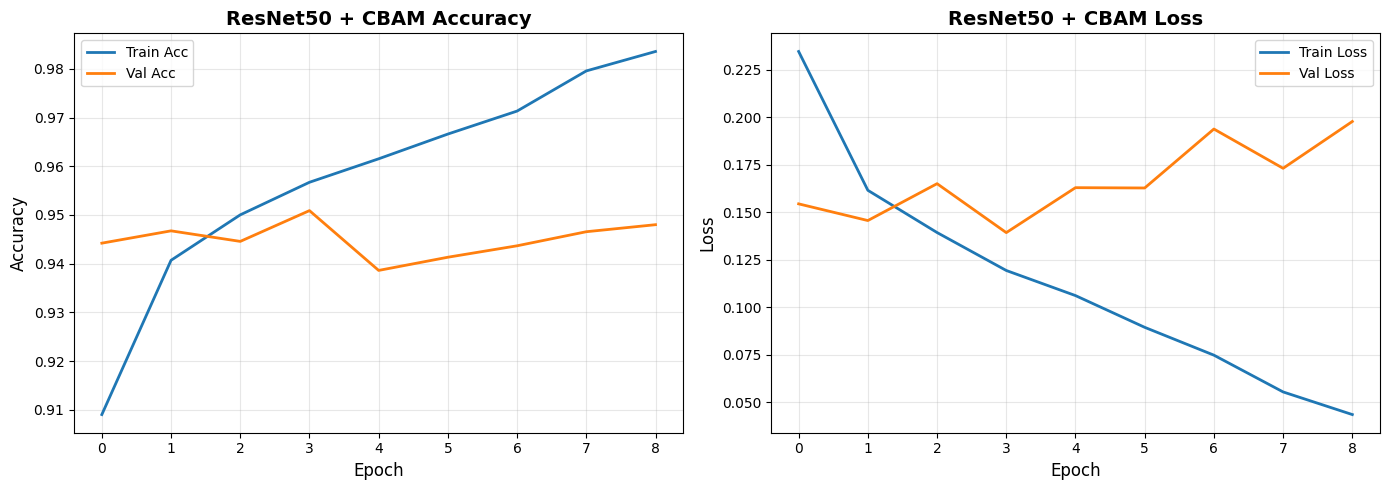

✓ Training curves saved to /content/malaria_detection/results/resnet50_cbam_training.png


In [13]:
import matplotlib.pyplot as plt

def plot_cbam_training_history(history, save_path):
    acc    = history.history['accuracy']
    val_acc= history.history['val_accuracy']
    loss   = history.history['loss']
    val_loss=history.history['val_loss']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy Curve
    axes[0].plot(acc, label='Train Acc', linewidth=2)
    axes[0].plot(val_acc, label='Val Acc', linewidth=2)
    axes[0].set_title('ResNet50 + CBAM Accuracy', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, alpha=0.3)

    # Loss Curve
    axes[1].plot(loss, label='Train Loss', linewidth=2)
    axes[1].plot(val_loss, label='Val Loss', linewidth=2)
    axes[1].set_title('ResNet50 + CBAM Loss', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Loss', fontsize=12)
    axes[1].legend(fontsize=10)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✓ Training curves saved to {save_path}")

# Use this after your training cell:
plot_cbam_training_history(
    cbam_history,
    f"{project_root}/results/resnet50_cbam_training.png"
)


In [16]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess # Import DenseNet preprocess


# ============================================================================
# STEP 9: COMPREHENSIVE MODEL EVALUATION (FIXED NAMING/PREPROCESSING)
# ============================================================================

# Ensure test set preprocessing matches training for each model:
X_test_cnn   = X_test                                    # Baseline CNN: [0,1] normalized images
X_test_resnet= resnet_preprocess(X_test * 255.0)         # ResNet50: preprocess_input
X_test_densenet = densenet_preprocess(X_test * 255.0)    # If you used preprocess_input for DenseNet121
X_test_cbam  = resnet_preprocess(X_test * 255.0)         # CBAM uses ResNet preprocess

# Model dictionary with correct names and inputs
models = [
    {'name': 'Baseline CNN',        'model': baseline_model,   'X': X_test_cnn},
    {'name': 'ResNet50',            'model': resnet_model,     'X': X_test_resnet},
    {'name': 'DenseNet121',         'model': densenet_model,   'X': X_test_densenet},
    {'name': 'ResNet50 + CBAM',     'model': cbam_model,       'X': X_test_cbam}
]

results = []

print("\n" + "="*60)
print("MODEL EVALUATION ON TEST SETS")
print("="*60)

for entry in models:
    name = entry['name']
    model = entry['model']
    X_inp = entry['X']

    print(f"\nEvaluating {name}...")
    y_pred_proba = model.predict(X_inp, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_val = roc_auc_score(y_test, y_pred_proba)

    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision': round(prec, 4),
        'Recall': round(rec, 4),
        'F1-Score': round(f1, 4),
        'AUC': round(auc_val, 4)
    })

    print(f"  Accuracy:  {acc:.4f}")
    print(f"  Precision: {prec:.4f}")
    print(f"  Recall:    {rec:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    print(f"  AUC:       {auc_val:.4f}")

metrics_df = pd.DataFrame(results)
metrics_df.to_csv(f'{project_root}/results/metrics_summary.csv', index=False)

print("\n" + "="*60)
print("FINAL RESULTS SUMMARY")
print("="*60)
print(metrics_df.to_string(index=False))

# Find best model
best_idx = metrics_df['AUC'].idxmax()
best_model_name = metrics_df.loc[best_idx, 'Model']
print(f"\n🏆 Best Model: {best_model_name} (AUC: {metrics_df.loc[best_idx, 'AUC']})")

# Save best model by searching dictionary
for entry in models:
    if entry['name'] == best_model_name:
        entry['model'].save(f'{project_root}/models/best_model.keras')
        print(f"✓ Best model saved as best_model.keras")
        break


MODEL EVALUATION ON TEST SETS

Evaluating Baseline CNN...
  Accuracy:  0.9300
  Precision: 0.9666
  Recall:    0.8908
  F1-Score:  0.9271
  AUC:       0.9762

Evaluating ResNet50...
  Accuracy:  0.9524
  Precision: 0.9688
  Recall:    0.9348
  F1-Score:  0.9515
  AUC:       0.9898

Evaluating DenseNet121...
  Accuracy:  0.7600
  Precision: 0.6773
  Recall:    0.9927
  F1-Score:  0.8052
  AUC:       0.9709

Evaluating ResNet50 + CBAM...
  Accuracy:  0.9469
  Precision: 0.9439
  Recall:    0.9501
  F1-Score:  0.9470
  AUC:       0.9867

FINAL RESULTS SUMMARY
          Model  Accuracy  Precision  Recall  F1-Score    AUC
   Baseline CNN    0.9300     0.9666  0.8908    0.9271 0.9762
       ResNet50    0.9524     0.9688  0.9348    0.9515 0.9898
    DenseNet121    0.7600     0.6773  0.9927    0.8052 0.9709
ResNet50 + CBAM    0.9469     0.9439  0.9501    0.9470 0.9867

🏆 Best Model: ResNet50 (AUC: 0.9898)
✓ Best model saved as best_model.keras



GENERATING RESEARCH-QUALITY VISUALIZATIONS


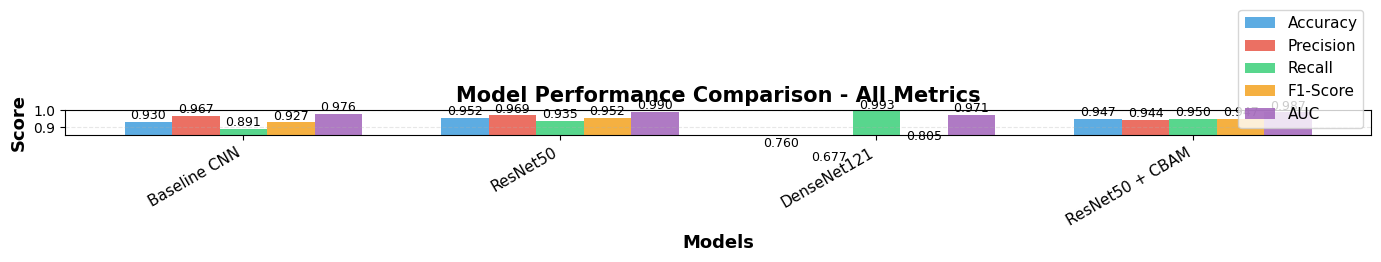

✓ Model comparison chart saved!


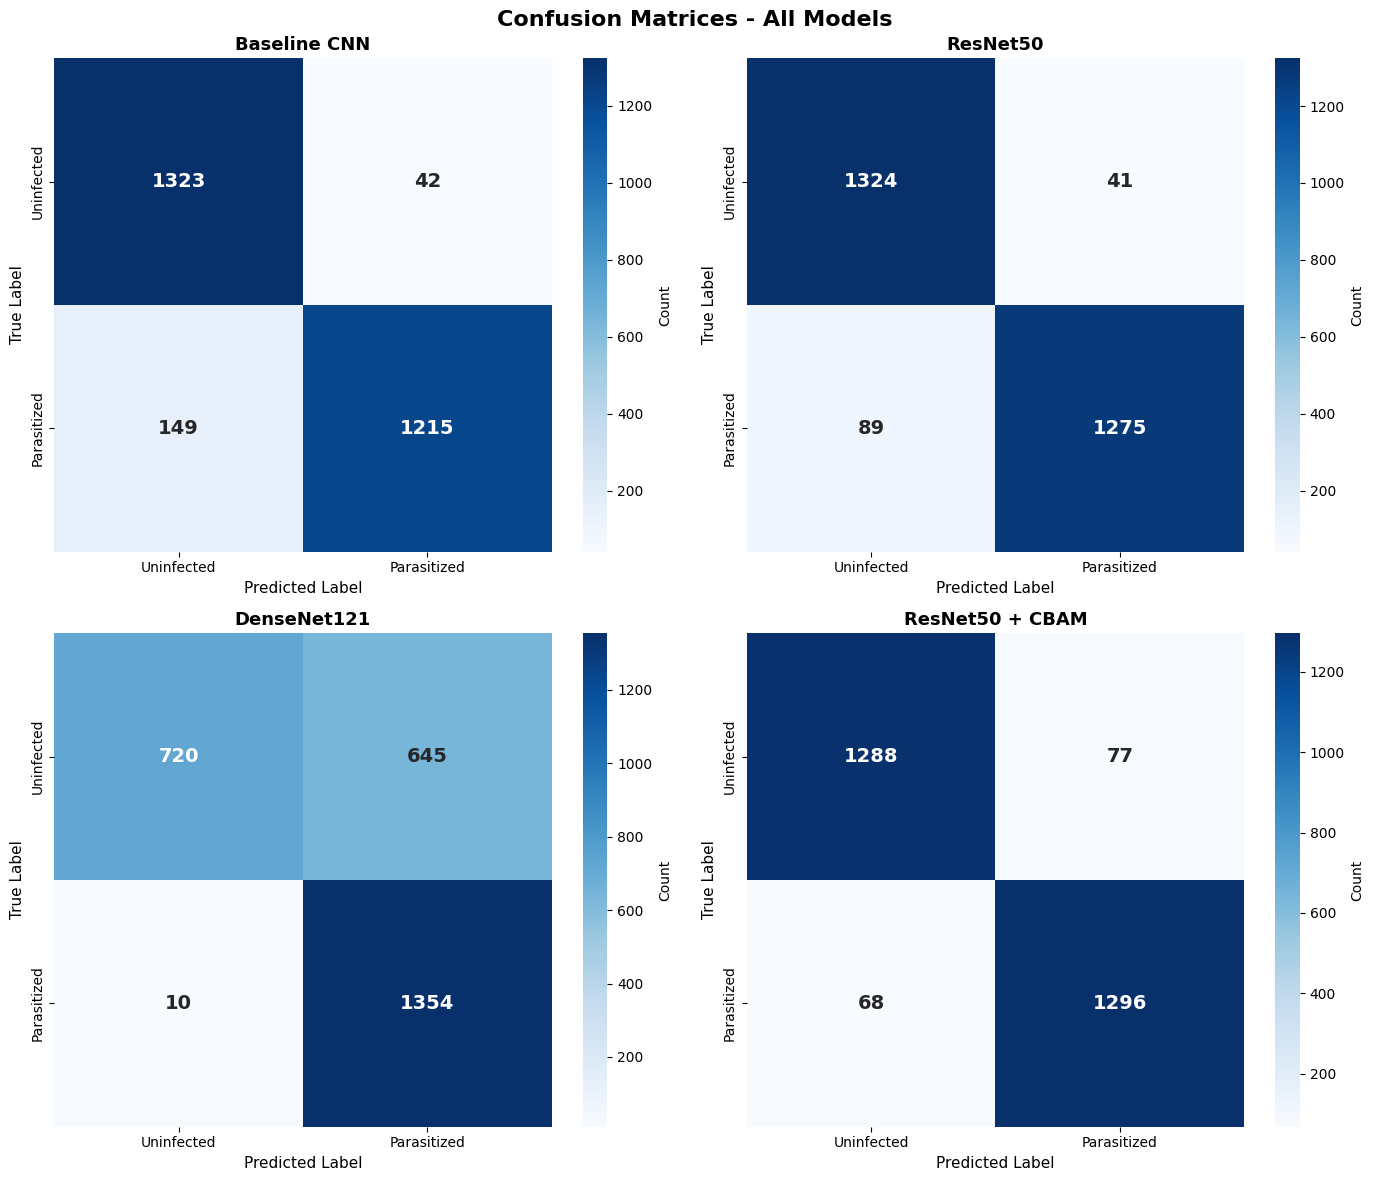

✓ Confusion matrices saved!


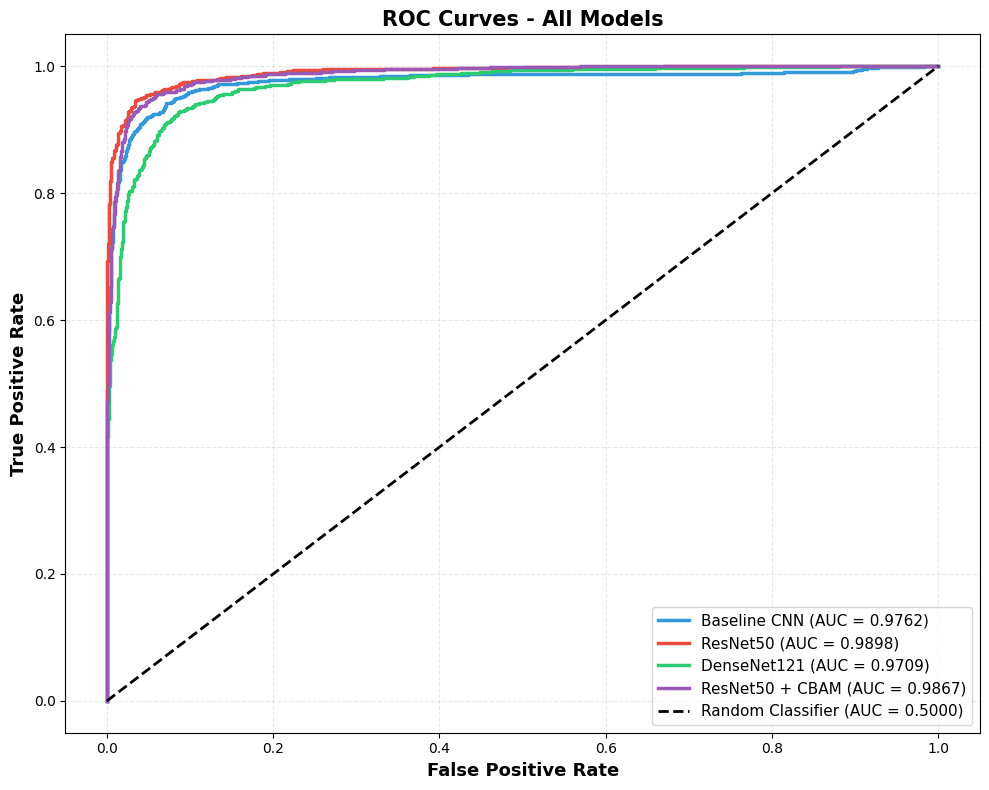

✓ ROC curves saved!


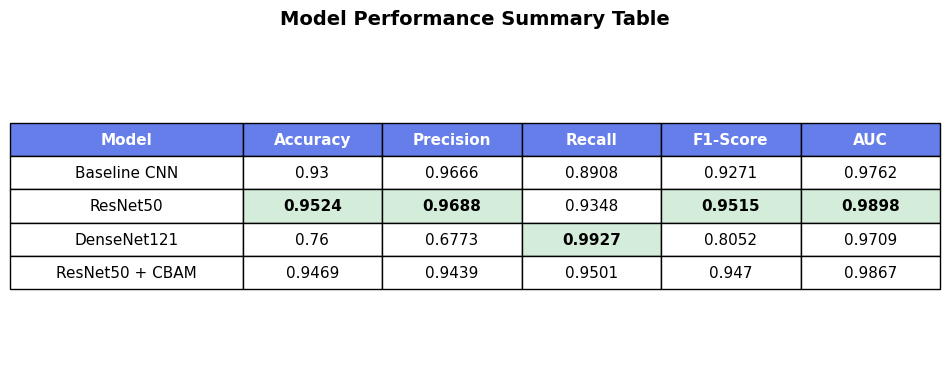

✓ Metrics table saved!

✓ All visualizations generated and saved!

DOWNLOADING RESULTS


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


🎉 PHASE 1 COMPLETE! ALL MODELS TRAINED AND EVALUATED SUCCESSFULLY!

📊 Summary:
   - 4 models trained and evaluated
   - Best model: ResNet50 (AUC: 0.9898)
   - All results saved to: /content/malaria_detection/results/

🚀 Ready for Phase 2: Flask Deployment!


In [18]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# ============================================================================
# STEP 10: GENERATE COMPREHENSIVE VISUALIZATIONS
# ============================================================================

print("\n" + "="*60)
print("GENERATING RESEARCH-QUALITY VISUALIZATIONS")
print("="*60)

# -----------------------------------------------------------------------------
# 1. MODEL PERFORMANCE COMPARISON BAR CHART
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(14, 7))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
x = np.arange(len(metrics_df))
width = 0.15

colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6']

for i, metric in enumerate(metrics_to_plot):
    bars = ax.bar(x + i*width, metrics_df[metric], width, label=metric, color=colors[i], alpha=0.8)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

ax.set_xlabel('Models', fontsize=13, fontweight='bold')
ax.set_ylabel('Score', fontsize=13, fontweight='bold')
ax.set_title('Model Performance Comparison - All Metrics', fontsize=15, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(metrics_df['Model'], rotation=30, ha='right', fontsize=11)
ax.legend(fontsize=11, loc='lower right')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0.85, 1.0])  # Adjust based on your results
plt.tight_layout()
plt.savefig(f'{project_root}/results/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Model comparison chart saved!")

# -----------------------------------------------------------------------------
# 2. CONFUSION MATRICES FOR ALL MODELS
# -----------------------------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Confusion Matrices - All Models', fontsize=16, fontweight='bold')

# Iterate over the list 'models'
for idx, entry in enumerate(models):
    name = entry['name']
    model = entry['model']
    X_test_input = entry['X']  # Use the correct input data from the entry

    row = idx // 2
    col = idx % 2
    ax = axes[row, col]

    # Predictions
    y_pred_proba = model.predict(X_test_input, verbose=0)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                cbar_kws={'label': 'Count'},
                annot_kws={'size': 14, 'weight': 'bold'})
    ax.set_title(name, fontsize=13, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=11)
    ax.set_ylabel('True Label', fontsize=11)
    ax.set_xticklabels(['Uninfected', 'Parasitized'], fontsize=10)
    ax.set_yticklabels(['Uninfected', 'Parasitized'], fontsize=10)

plt.tight_layout()
plt.savefig(f'{project_root}/results/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Confusion matrices saved!")

# -----------------------------------------------------------------------------
# 3. ROC CURVES WITH AUC COMPARISON
# -----------------------------------------------------------------------------

plt.figure(figsize=(10, 8))

colors_roc = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

# Iterate over the list 'models'
for idx, entry in enumerate(models):
    name = entry['name']
    model = entry['model']
    X_test_input = entry['X'] # Use the correct input data from the entry

    # Predictions
    y_pred_proba = model.predict(X_test_input, verbose=0)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)

    plt.plot(fpr, tpr, linewidth=2.5, label=f'{name} (AUC = {auc_score:.4f})',
             color=colors_roc[idx])

# Random classifier line
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier (AUC = 0.5000)')

plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('ROC Curves - All Models', fontsize=15, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig(f'{project_root}/results/roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ ROC curves saved!")

# -----------------------------------------------------------------------------
# 4. SUMMARY TABLE VISUALIZATION
# -----------------------------------------------------------------------------

fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

table = ax.table(cellText=metrics_df.values,
                colLabels=metrics_df.columns,
                cellLoc='center',
                loc='center',
                colWidths=[0.25, 0.15, 0.15, 0.15, 0.15, 0.15])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2)

# Style header
for i in range(len(metrics_df.columns)):
    table[(0, i)].set_facecolor('#667eea')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best scores
for i in range(1, len(metrics_df) + 1):
    for j in range(1, len(metrics_df.columns)):
        if metrics_df.iloc[i-1, j] == metrics_df.iloc[:, j].max():
            table[(i, j)].set_facecolor('#d4edda')
            table[(i, j)].set_text_props(weight='bold')

plt.title('Model Performance Summary Table', fontsize=14, fontweight='bold', pad=20)
plt.savefig(f'{project_root}/results/metrics_table.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Metrics table saved!")

print("\n✓ All visualizations generated and saved!")

# -----------------------------------------------------------------------------
# 5. DOWNLOAD RESULTS (GOOGLE COLAB)
# -----------------------------------------------------------------------------

print("\n" + "="*60)
print("DOWNLOADING RESULTS")
print("="*60)

from google.colab import files

# Download best model
print("Downloading best model...")
files.download(f'{project_root}/models/best_model.keras')

# Download metrics CSV
print("Downloading metrics summary...")
files.download(f'{project_root}/results/metrics_summary.csv')

# Download all visualizations
print("Downloading visualizations...")
files.download(f'{project_root}/results/model_comparison.png')
files.download(f'{project_root}/results/confusion_matrices.png')
files.download(f'{project_root}/results/roc_curves.png')
files.download(f'{project_root}/results/metrics_table.png')

# Download individual model training curves (if saved earlier)
try:
    files.download(f'{project_root}/results/baseline_cnn_training.png')
    files.download(f'{project_root}/results/resnet50_training.png')
    files.download(f'{project_root}/results/densenet121_training.png')
    files.download(f'{project_root}/results/resnet50_cbam_training.png')
except:
    print("Note: Some individual training curves not found (skip if not generated)")

print("\n" + "="*80)
print("🎉 PHASE 1 COMPLETE! ALL MODELS TRAINED AND EVALUATED SUCCESSFULLY!")
print("="*80)
print("\n📊 Summary:")
print(f"   - {len(models)} models trained and evaluated")
print(f"   - Best model: {best_model_name} (AUC: {metrics_df.loc[best_idx, 'AUC']})")
print(f"   - All results saved to: {project_root}/results/")
print("\n🚀 Ready for Phase 2: Flask Deployment!")

In [19]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [20]:
import os

gdrive_root = '/content/drive/My Drive/malaria'
if not os.path.exists(gdrive_root):
    os.makedirs(gdrive_root)

# Optionally, mirror your internal project structure
os.makedirs(f'{gdrive_root}/models', exist_ok=True)
os.makedirs(f'{gdrive_root}/results', exist_ok=True)
os.makedirs(f'{gdrive_root}/plots', exist_ok=True)
os.makedirs(f'{gdrive_root}/data', exist_ok=True)  # If you want to save datasets or CSVs


In [21]:
import shutil

# Copy whole model and results folders
shutil.copytree(f"{project_root}/models",   f"{gdrive_root}/models", dirs_exist_ok=True)
shutil.copytree(f"{project_root}/results",  f"{gdrive_root}/results", dirs_exist_ok=True)

# If you want to store notebooks or source files too:
notebook_name = 'your_notebook_name.ipynb' # Replace with actual notebook name if you wish
if os.path.exists(notebook_name):
    shutil.copy2(notebook_name, gdrive_root)


In [22]:
# Example: Load best model
from tensorflow.keras.models import load_model
best_model = load_model(f'{gdrive_root}/models/best_model.keras')
